In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import chi2

In [7]:
eco = pd.read_excel('data/economicdata.xls')
eco.head()

,Unnamed: 0,nikkei225,topix,indprod,exrate,cpi,saunemp,intrate
0,1975-01-01,3767.09,276.09,47.33,29.13,52.625,1.7,12.67
1,1975-02-01,4100.97,299.81,46.86,29.70,52.723,1.8,13.00
2,1975-03-01,4300.08,313.50,46.24,29.98,53.114,1.8,12.92
3,1975-04-01,4435.26,320.57,47.33,29.80,54.092,1.8,12.02
4,1975-05-01,4506.24,329.65,47.33,29.79,54.385,1.8,11.06


# グラフ化

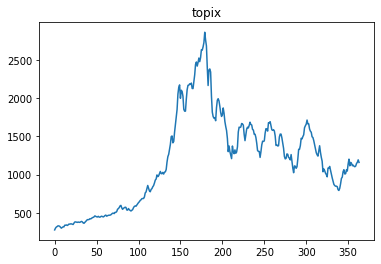

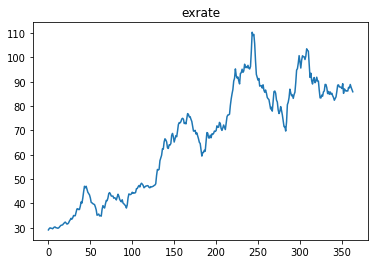

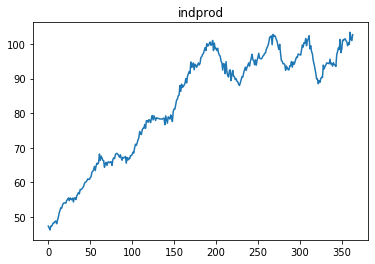

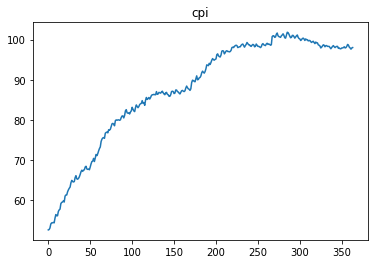

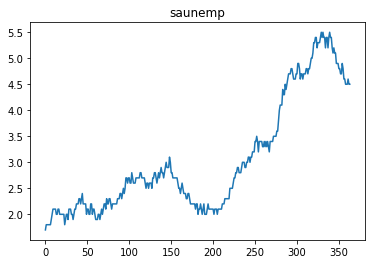

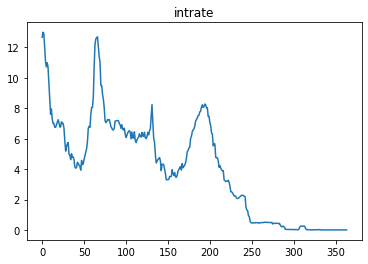

In [8]:
col = ['topix', 'exrate', 'indprod', 'cpi', 'saunemp', 'intrate']

for i in col:
    plt.plot(eco[i])
    plt.title(i)
    plt.show()

# 変化率の系列（対数差分系）をグラフ化


In [9]:
col_dlog = []
for i in col:
    eco[i+'dlog'] = np.log(eco[i]).diff()
    col_dlog.append(i+'dlog')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/pandas/core/algorithms.py:1819: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


In [10]:
eco.head()

,Unnamed: 0,nikkei225,topix,indprod,exrate,cpi,saunemp,intrate,topixdlog,exratedlog,indproddlog,cpidlog,saunempdlog,intratedlog
0,1975-01-01,3767.09,276.09,47.33,29.13,52.625,1.7,12.67,NaN,NaN,NaN,NaN,NaN,NaN
1,1975-02-01,4100.97,299.81,46.86,29.70,52.723,1.8,13.00,0.082422,0.019378,-0.009980,0.001861,0.057158,0.025712
2,1975-03-01,4300.08,313.50,46.24,29.98,53.114,1.8,12.92,0.044650,0.009383,-0.013319,0.007389,0.000000,-0.006173
3,1975-04-01,4435.26,320.57,47.33,29.80,54.092,1.8,12.02,0.022301,-0.006022,0.023299,0.018246,0.000000,-0.072205
4,1975-05-01,4506.24,329.65,47.33,29.79,54.385,1.8,11.06,0.027931,-0.000336,0.000000,0.005402,0.000000,-0.083237


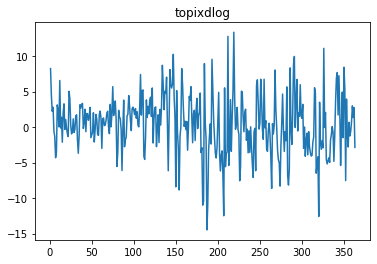

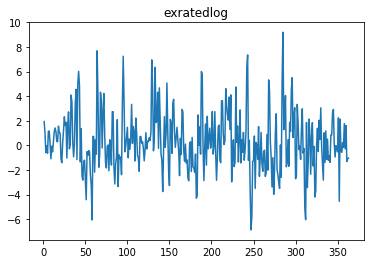

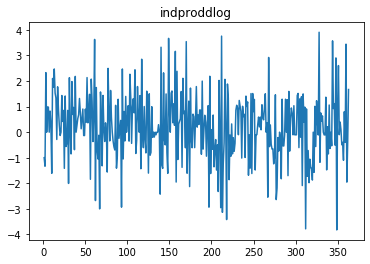

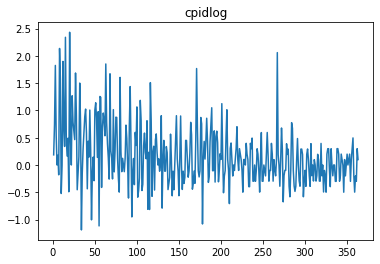

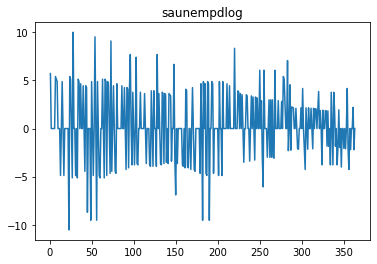

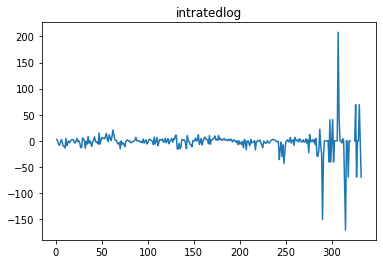

In [11]:
for i in col_dlog:
    plt.plot(eco[i] * 100)
    plt.title(i)
    plt.show()

In [12]:
col_dlog = ['topixdlog', 'exratedlog', 'indproddlog']

## 期待値
$$
\bar{y} = \frac{1}{T} \sum^{T}_{t=1} y_t 
$$

In [13]:
def time_mean(t_data):
    return np.mean(t_data)

## 自己共分散 autocovariance

$$
\hat{\gamma_k} = \frac{1}{T} \sum^{T}_{t=k+1}(y_t - \bar{y})(y_{t-k} - \bar{y})  \\
k = 0 ,1, 2, , 3, ...
$$

In [27]:
def time_acv(t_data, k):
    T = len(t_data)
    t = k + 1
    n = T - t
    
    mu = time_mean(t_data[1:])
    
    #print('mu:', mu)
    gamma  = np.sum((t_data[t:] - mu) * (t_data[1:n+1] - mu)) / T
    return gamma

## 自己相関係数 autocorrelation coefficient

$$
\hat{\rho_k} = \frac{\hat{\gamma_k}}{\hat{\gamma_0}}  \\
k = 1, 2, 3, ...
$$

In [15]:
def time_acr(t_data, k):
    gamma_k  = time_acv(t_data, k)
    gamma_0 = time_acv(t_data, 0)

    rho_k = gamma_k / gamma_0 
    return rho_k

## かばん検定 portmanteau test
Ljung-Box検定  
https://ja.wikipedia.org/wiki/リュング・ボックス検定

$$
Q(m) = T(T+2)\sum^{m}_{k=1}\frac{\hat{\rho_k}^2}{T-k} \sim \chi^2(m)
$$

In [16]:
def portmanteau_test(t_data, m):
    T = len(t_data)
    tmp = 0
    
    Q = T*(T+2)
    
    for i in range(m):
        k = i+1
        rho_k = time_acr(t_data, k)
        tmp += rho_k ** 2 / (T - k)
        
    Q = Q * tmp
    
    alpha = chi2.ppf(0.95, m)
    
    p = chi2.pdf(Q, m)

    if Q > alpha:
        print("lag:", m, "データは有意な自己相関を持つ")
    return rho_k, Q, p

In [17]:
def bar_plot(d_time, lag_n=20):
    ac_list = []
    lag_list = []
    
    for i in range(lag_n):
        lag_list.append(i+1)
        ac_list.append(time_acr(d_time, i+1))
        
    plt.bar(lag_list, ac_list)
    plt.xlim([0, lag_n+1]) 
    plt.ylim([-0.5, 0.5])
    plt.grid(which = "major", axis = "y")
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')
    plt.show()

## indprodの変化率

In [18]:
ind_dlog = eco['indproddlog'].values.copy() 

In [19]:
time_acv(ind_dlog, 1)

-5.406621201297378e-05

In [20]:
time_acr(ind_dlog, 1)

-0.30568150702942737

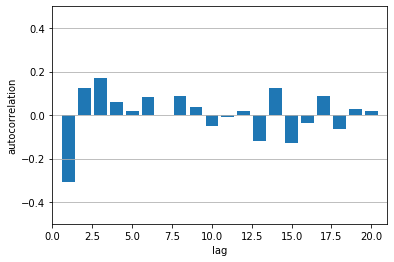

In [21]:
bar_plot(ind_dlog)

In [22]:
lag_list = []
Q_list = []
p_list = []
rho_list = []

for i in range(10):
    rho, Q, p = portmanteau_test(ind_dlog, i+1)
    lag_list.append(i+1)
    rho_list.append(rho)
    Q_list.append(Q)
    p_list.append(p)

lag: 1 データは有意な自己相関を持つ
lag: 2 データは有意な自己相関を持つ
lag: 3 データは有意な自己相関を持つ
lag: 4 データは有意な自己相関を持つ
lag: 5 データは有意な自己相関を持つ
lag: 6 データは有意な自己相関を持つ
lag: 7 データは有意な自己相関を持つ
lag: 8 データは有意な自己相関を持つ
lag: 9 データは有意な自己相関を持つ
lag: 10 データは有意な自己相関を持つ


In [23]:
test=pd.DataFrame({'lag':lag_list,'autocorr': rho_list, 
                         'Q(m)':Q_list, 'P_value':p_list})
test = test.T
test.round(2)

,0,1,2,3,4,5,6,7,8,9
lag,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00
autocorr,-0.31,0.12,0.17,0.06,0.02,0.08,-0.00,0.09,0.04,-0.05
Q(m),34.29,39.87,50.53,51.95,52.05,54.61,54.61,57.61,58.09,59.00
P_value,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
